In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import MarkovAutoregression
from statsmodels.tsa.stattools import adfuller

In [150]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

Изучим данные. 

In [151]:
df = pd.read_csv("../../General_ds_cleaned.csv")
df = df[["date", "0.25", "0.5", "0.75", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "15.0", "20.0", "30.0"]]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", drop=True, inplace=True)
df

,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0
date,,,,,,,,,,,,
2003-01-04,11.68,12.31,12.76,13.08,13.63,13.72,13.63,13.53,13.45,13.38,13.35,13.32
2003-01-05,11.09,11.70,12.16,12.50,13.14,13.30,13.31,13.27,13.23,13.20,13.19,13.17
2003-01-08,10.84,11.61,12.15,12.53,13.18,13.30,13.29,13.24,13.19,13.15,13.13,13.11
2003-01-09,10.46,11.13,11.67,12.09,13.02,13.31,13.38,13.32,13.25,13.19,13.16,13.13
2003-01-10,10.10,11.08,11.79,12.28,13.14,13.31,13.27,13.19,13.11,13.04,13.00,12.97
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,13.29,12.15,11.71,11.55,11.52,11.54,11.61,11.68,11.74,11.78,11.78,11.77
2023-11-28,13.15,12.13,11.74,11.60,11.57,11.54,11.57,11.65,11.73,11.77,11.77,11.77
2023-11-29,13.30,12.05,11.58,11.43,11.49,11.53,11.59,11.65,11.71,11.74,11.75,11.75


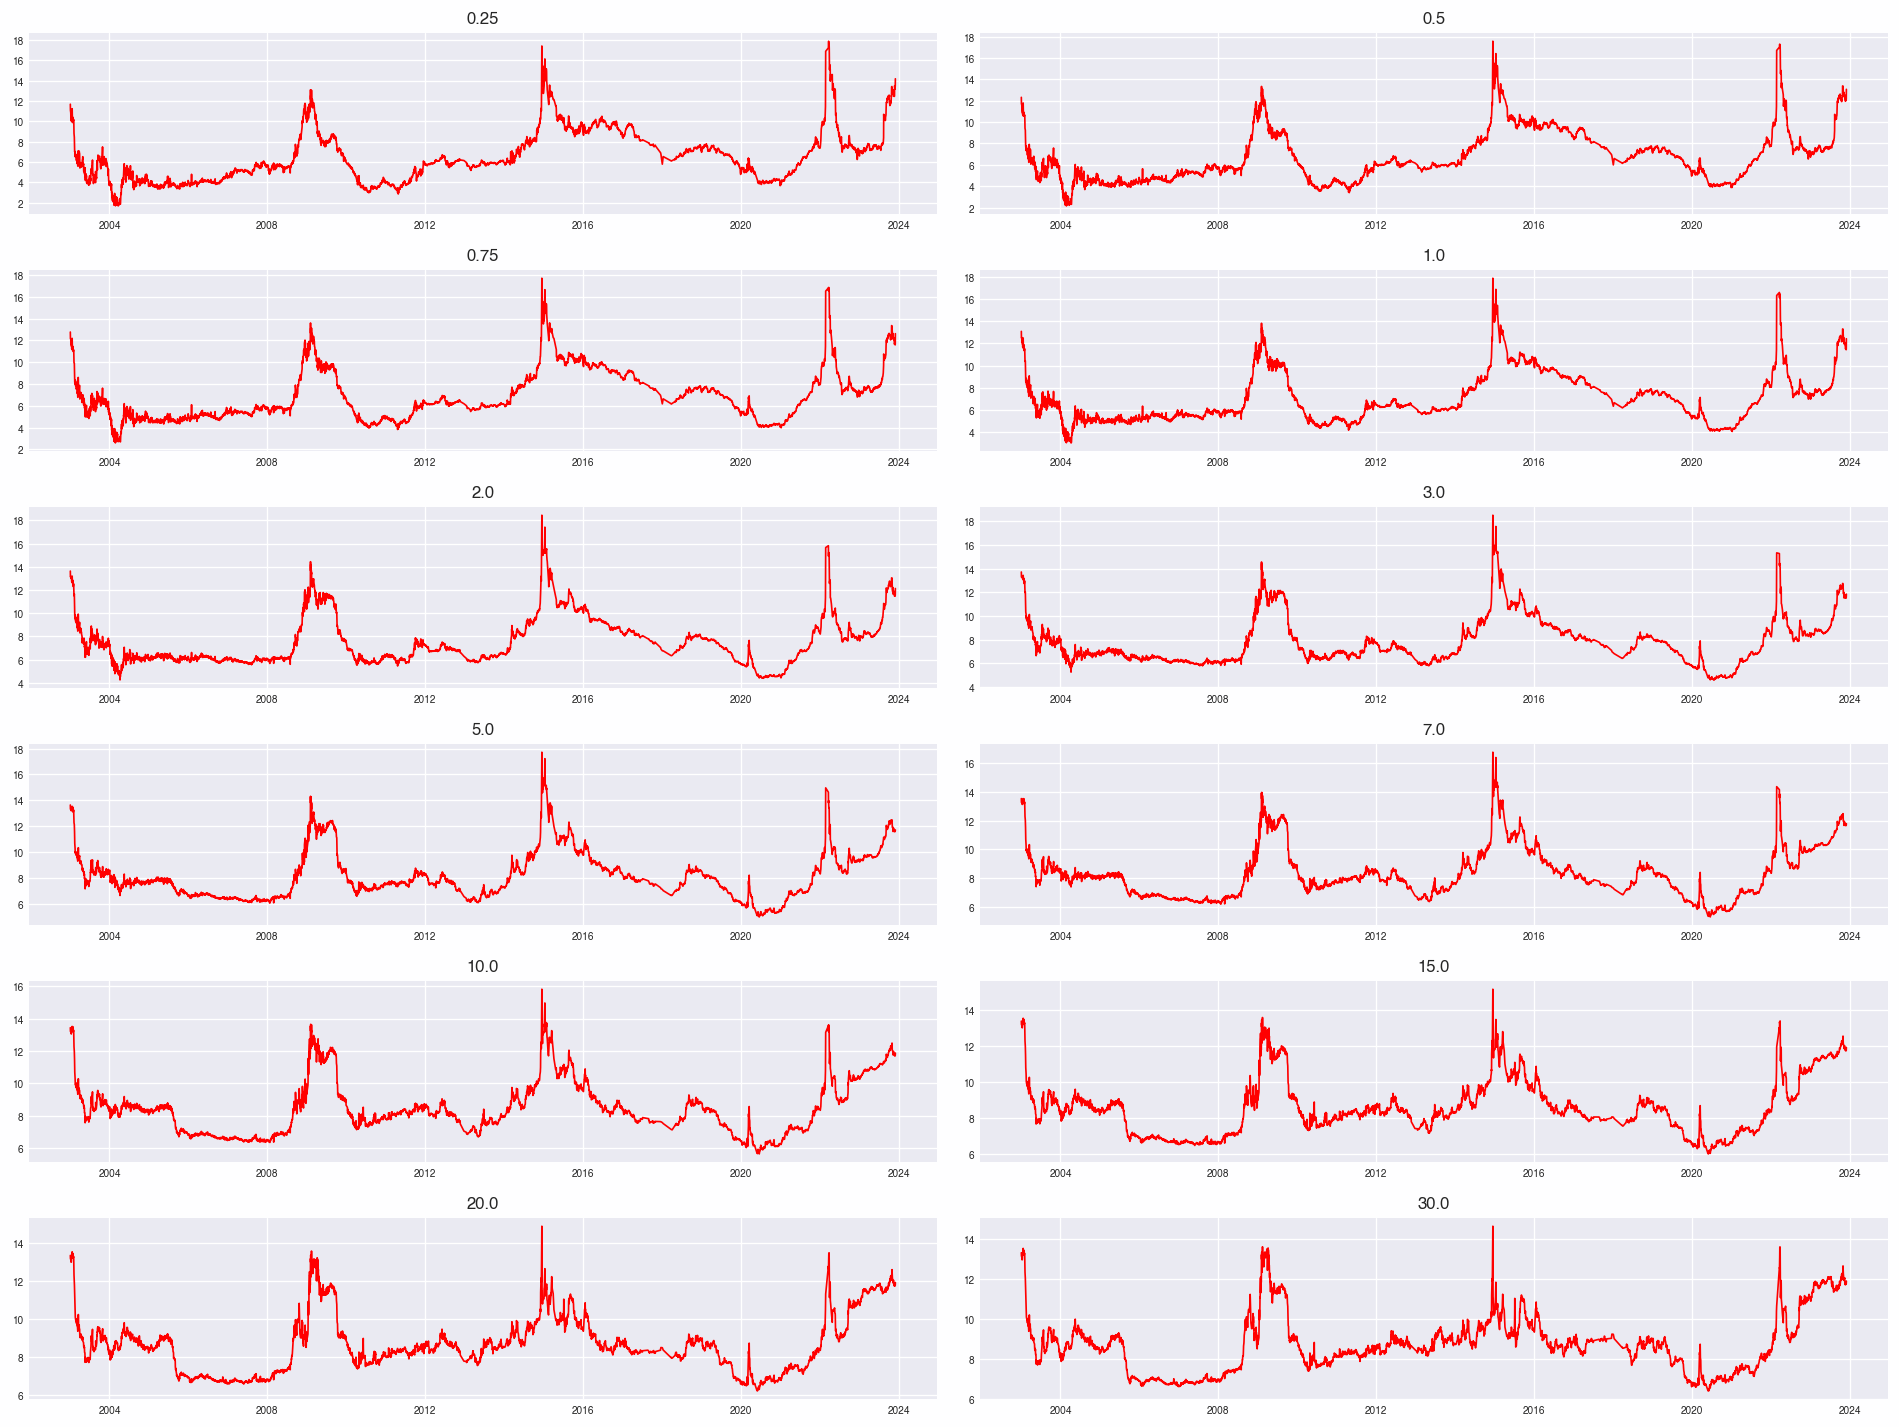

In [152]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(16,12))
for i, ax in enumerate(axes.flat):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Теперь приступим к разбивке на test и train(с помощью дат полученных из структурных сдвигов). Для train вычитают 5 дней от структурного сдвига, а промежуток в 5 дней беру на test.
### МЕНЯТЬ ТОЛЬКО ЗДЕСЬ!!!
1. n_horizon — количество дней, на которое предсказываем 
1. epoch — промежуток, который исследуем

In [153]:
n_horizon = 5
dates_from_struct_ms = np.array([0, 657, 1384, 1500, 2700, 3000, 3943, 4502])


time_to_fit = np.maximum((dates_from_struct_ms - n_horizon), np.zeros(len(dates_from_struct_ms))).astype(int)
time_to_predict = dates_from_struct_ms

epoch = 4
df_train, df_test = df[time_to_fit[epoch]:time_to_fit[epoch + 1]], df[time_to_fit[epoch + 1]:time_to_predict[epoch + 1]]

<Axes: xlabel='date'>

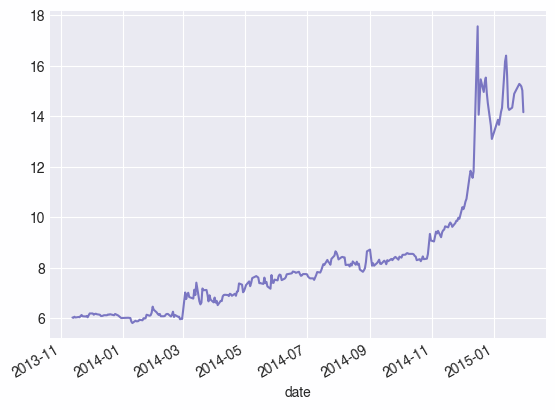

In [154]:
df_train["0.5"].plot()

Проверим на стационарность.

In [155]:
def adjust(val, length= 6): return str(val).ljust(length)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [156]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "0.25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.2538
 No. Lags Chosen       = 2
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.9751. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "0.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.3732
 No. Lags Chosen       = 2
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.9805. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "0.75" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root.

Получили, что все не стационарно. Возьмем разницу и снова проверим.

In [167]:
df_differenced = df_train.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "0.25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.9565
 No. Lags Chosen       = 1
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.7115
 No. Lags Chosen       = 1
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.75" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [157]:
# model_markov = MarkovAutoregression(df_train["0.5"], k_regimes=2, order=4, trend="t")